In [635]:
# coding=utf8

import pandas as pd
import numpy as np
from sklearn.svm import SVC
import matplotlib.pyplot as plt

In [636]:
# 加载数据
df0 = pd.read_csv('data/DQC00-1d.txt',
                  sep=',',
                  nrows=5000,
                  index_col=['datetime'],  # 设置行索引
                  parse_dates=['datetime'],  # 解析时间 20100104130500.0
                  date_parser=lambda x: pd.to_datetime(x, format='%Y%m%d%H%M%S.%f'),  # 时间解析的格式，进行毫秒级数据解析
                  usecols=['datetime', 'open', 'high', 'low', 'close', 'volume'],  # 设置需要用到的列
                  encoding='utf-8',
                  float_precision='round_trip',  # 所有数据会当做string读取, 使用时再进行相应的转换为float
                  )
# pd.reset_option('display.float_format')  # 重置
pd.set_option('precision', 2)  # 显示小数点后的位数
pd.set_option('display.max_rows', 300)  # 控制显示的最大行数
pd.set_option('display.min_rows', 20)  # 确定显示的部分有多少行
pd.options.display.float_format = '{:.2f}'.format  # 统一设置小数位数
# pd.set_option('display.float_format',  '{:,.2f}'.format) # 数字格式化显示 用逗号格式化大值数字 设置数字精度
# 指定列名设置计算精确度，未指定的保持原样
df0.round({'open': 0, 'high': 0, 'low': 0, 'close': 0})
df0.round(2)  ## 统一设置小数位数
#设定numpy显示浮点数精度的小数位数,不使用科学记数法
np.set_printoptions(precision=2, suppress=True)

In [637]:
print(df0.dtypes)
df0.head(20)

open      float64
high      float64
low       float64
close     float64
volume    float64
dtype: object


,open,high,low,close,volume
datetime,,,,,
2004-09-22,1143.23,1147.88,1106.05,1106.98,77908.00
2004-09-23,1097.68,1099.54,1089.32,1093.04,37196.00
2004-09-24,1082.81,1101.40,1082.81,1095.83,29367.00
2004-09-27,1092.11,1100.47,1075.38,1076.31,17336.00
2004-09-28,1077.24,1088.39,1077.24,1082.81,26681.00
2004-09-29,1083.74,1086.53,1069.80,1073.52,25441.00
2004-09-30,1067.01,1070.73,1046.56,1047.49,26989.00
2004-10-08,1049.35,1069.80,1037.27,1064.22,31094.00
2004-10-11,1062.37,1075.38,1053.07,1066.08,25683.00


In [638]:
# 2.1 缺失值处理
print('返回每一列缺失值统计个数:', df0.isnull().sum())
df0 = df0.dropna(axis=0, how='any')  #删除包含缺失值的行
print('检查数据中是否有缺失值:', df0.isnull().any())


返回每一列缺失值统计个数: open      0
high      0
low       0
close     0
volume    0
dtype: int64
检查数据中是否有缺失值: open      False
high      False
low       False
close     False
volume    False
dtype: bool


In [639]:
# 截取时间段内样本数据
df = df0["2021-01-01":].copy()
print(df[10:20])
print('df is df0: ', df.values is df0.values)
# df.drop(df.index, inplace=True)
# df=df.drop(index=df.index)

              open    high     low   close    volume
datetime                                            
2021-01-18 2780.56 2814.41 2777.66 2786.37 727775.00
2021-01-19 2782.50 2801.84 2758.32 2773.79 625718.00
2021-01-20 2773.79 2779.60 2738.98 2751.55 636369.00
2021-01-21 2753.48 2778.63 2746.71 2755.42 546861.00
2021-01-22 2751.55 2766.06 2712.86 2728.34 832591.00
2021-01-25 2727.37 2743.81 2661.60 2680.95 945135.00
2021-01-26 2680.95 2699.32 2673.21 2681.91 502124.00
2021-01-27 2686.75 2704.16 2666.44 2674.18 666309.00
2021-01-28 2677.08 2683.85 2635.49 2637.42 737921.00
2021-01-29 2640.33 2647.10 2615.18 2624.85 622614.00
df is df0:  False


In [640]:

pd.options.display.float_format = '{:.2f}'.format  # 统一设置小数位数
# 截取时间段内样本数据
df = df0["2021-01-01":].copy()

epsilon = 0.01  #误差百分比
# 与前几周期的变动百分比
df.insert(len(df.columns), 'flag', df.close.pct_change(5), allow_duplicates=True)
df.loc[(df.flag.between(-epsilon, epsilon)), 'flag'] = 0
# df.loc[:,'flag'] = df.apply(lambda d: 1 if (d.flag > 0) else (-1 if (d.flag < 0) else 0), axis=1)
df.loc[df.flag.gt(0), 'flag'] = 1
df.loc[df.flag < 0, 'flag'] = -1
print(df.head())

# 2.1 缺失值处理
print('返回每一列缺失值统计个数:', df.isnull().sum())
df = df.dropna(axis=0, how='any')  #删除包含缺失值的行
print('检查数据中是否有缺失值:', df.isnull().any())


              open    high     low   close    volume  flag
datetime                                                  
2021-01-04 2664.50 2687.72 2650.96 2655.80 633210.00   NaN
2021-01-05 2654.83 2686.75 2654.83 2678.04 472285.00   NaN
2021-01-06 2683.85 2706.09 2679.01 2694.49 481959.00   NaN
2021-01-07 2694.49 2718.66 2692.55 2713.83 510463.00   NaN
2021-01-08 2717.70 2746.71 2710.93 2742.84 630350.00   NaN
返回每一列缺失值统计个数: open      0
high      0
low       0
close     0
volume    0
flag      5
dtype: int64
检查数据中是否有缺失值: open      False
high      False
low       False
close     False
volume    False
flag      False
dtype: bool


In [641]:
# 2.2 确定特征值 目标值
# df.reset_index(level=0, inplace=True)   #时间索引成为列

# 特征值取 开 高 低 收 价
X = df.loc[:, ['open', 'high', 'low', 'close']].values
print(type(X), X.ndim, X.shape)
print(X[:3, ])

# 目标值取收盘
Y = df.loc[:, 'flag'].values
print(type(Y), Y.shape, Y.ndim)
print(Y[:100])



<class 'numpy.ndarray'> 2 (208, 4)
[[2748.65 2815.38 2708.99 2743.81]
 [2746.71 2780.56 2714.8  2773.79]
 [2777.66 2833.76 2771.86 2777.66]]
<class 'numpy.ndarray'> (208,) 1
[ 1.  1.  1.  1.  1.  1.  0.  0.  0. -1. -1. -1. -1. -1. -1.  0.  0.  0.
  1.  1.  0.  0.  0.  1.  0.  1.  0.  1.  0. -1.  0.  0. -1. -1.  1.  1.
  0. -1. -1. -1. -1. -1.  0.  0.  0.  0.  0.  0.  0.  0. -1. -1. -1. -1.
 -1.  0.  0.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  0.  0.  0.  1.  1.  1.  1.  1. -1. -1. -1. -1. -1.  0. -1. -1. -1. -1.
 -1. -1. -1.  1.  1.  1.  1.  0.  0.  0.]


In [642]:
print(type(X), X.shape, X.ndim)
print(type(Y), Y.shape, Y.ndim)

<class 'numpy.ndarray'> (208, 4) 2
<class 'numpy.ndarray'> (208,) 1


In [643]:
#将数据划分为训练集和验证集
from sklearn.model_selection import train_test_split

x_train_stand, x_test_stand, y_train, y_test = train_test_split(
    X, Y.reshape(-1, 1),
    random_state=1,  #如果为整形数字,则数据随机打乱顺序固定, 如果为random_state=None,则每次数据打乱顺序都不一样
    test_size=0.50,  #测试集50%样本数量
    shuffle=True,  #default=True 切分前是否对数据进行打乱。
)

In [644]:
## 混淆测试集目标类别的 指定概率50%的错误
# err = y_train
# for i in range(int(len(err) * 0.0)):
#     index = int(np.random.randint(len(err)))
#     err[index] = 0 if err[index] == 1 else 1
# 查看测试集是否与未混淆后不同
# print(np.sum(y_train>0)+np.sum(y_test>0), np.sum(Y>0))


In [645]:
# 3. 特征工程（标准化）
from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()

# 训练集 计算平均值和标准偏差
x_train_stand = standardScaler.fit_transform(x_train_stand)
# 以训练集的平均值和标准偏差来缩放测试集
x_test_stand = standardScaler.transform(x_test_stand)

y_train_stand = y_train
y_test_stand = y_test

In [646]:
# 目标类别为0，1 不用标准化
print(y_train[:5])
print(type(x_train_stand), x_train_stand.shape, x_train_stand.ndim)
print(type(y_train), y_train.shape, y_train.ndim)

[[ 0.]
 [-1.]
 [ 0.]
 [ 0.]
 [-1.]]
<class 'numpy.ndarray'> (104, 4) 2
<class 'numpy.ndarray'> (104, 1) 2


In [647]:
c = 300
# 拟合分类模型
linear = SVC(kernel='linear', C=c, gamma='scale', probability=True)
rbf = SVC(kernel='rbf', C=c, gamma='scale', probability=True)
poly = SVC(kernel='poly', C=c, gamma='scale', degree=3, coef0=1, probability=True)

kernel = [linear, rbf, poly]
kernel_label = ["linear", "rbf", "poly"]
for ix, svc in enumerate(kernel[:-1]):
    performance = svc.fit(x_train_stand, y_train.ravel())
    # 获取预测值
    y_test_pred = performance.predict(x_test_stand)
    # 显示估计器
    print(ix, svc.kernel, kernel[ix], 'sv:', svc.support_vectors_.shape)
    # 获取这个估计器的参数
    svc_params = svc.get_params()
    print(
        f'估计器的参数: kernel=%s, c=%s, gamma=%s' % (svc_params.get('kernel'), svc_params.get('C'), svc_params.get('gamma')))
    # https://blog.csdn.net/gracejpw/article/details/101546293
    # 返回预测的决定系数R^2
    # R^2越接近于1，模型的拟合优度越高。
    print(f'训练集R2评分: %s ' % (performance.score(x_train_stand, y_train)))
    print(f'测试集R2评分: %s ' % (svc.score(x_test_stand, y_test)))
    print()

0 linear SVC(C=300, kernel='linear', probability=True) sv: (84, 4)
估计器的参数: kernel=linear, c=300, gamma=scale
训练集R2评分: 0.5865384615384616 
测试集R2评分: 0.4807692307692308 

1 rbf SVC(C=300, probability=True) sv: (81, 4)
估计器的参数: kernel=rbf, c=300, gamma=scale
训练集R2评分: 0.7115384615384616 
测试集R2评分: 0.47115384615384615 



0 linear svcs: SVC(C=300, kernel='linear', probability=True)
sv__s: (84, 2) sv__sum: 168 sv_mean: 2623.38 [[2625.32 2642.29 2604.53 2621.4 ]]
sv__av:15.62 std:96.69 max:2836.18 min:2429.00 sv_sum:13910.07
训练集评分:0.59
测试集评分:0.48 预测精度得分:0.48

1 rbf svcs: SVC(C=300, probability=True)
sv__s: (81, 2) sv__sum: 162 sv_mean: 2621.69 [[2622.93 2640.62 2602.53 2620.67]]
sv__av:16.18 std:96.66 max:2833.76 min:2429.00 sv_sum:13302.65
训练集评分:0.71
测试集评分:0.47 预测精度得分:0.47



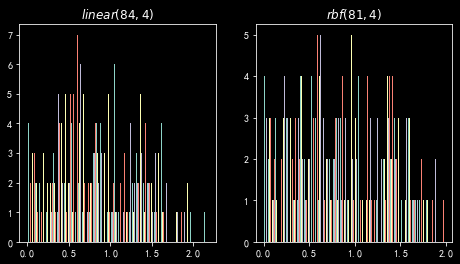

In [648]:
from sklearn.metrics import accuracy_score

plt.figure(figsize=(12, 4))
xx = np.vstack((x_train_stand[:, ], x_test_stand[:, ]))
yy = np.vstack((y_train.reshape(-1, 1), y_test.reshape(-1, 1)))
x_min, x_max = xx.min() - 0.5, xx.max() + 0.5
y_min, y_max = yy.min() - 0.5, yy.max() + 0.5

kernel = [linear, rbf, poly]
kernel_label = ["linear", "rbf", "poly"]
for ix, svc in enumerate(kernel[:-1]):
    fit = svc.fit(x_train_stand, y_train.ravel())
    # 获取预测值
    y_test_pred = fit.predict(x_test_stand)
    # 获取这个估计器的参数
    svr_params = svc.get_params()
    print(ix,
          svc.kernel,
          'svcs:', kernel[ix])

    sv_ = fit.support_vectors_
    sv = sv_.shape  #支持向量
    sv__ = standardScaler.inverse_transform(sv_)
    sv__h = np.hstack((np.amax(abs(sv__), axis=1).reshape(-1, 1),
                       np.amin(abs(sv__), axis=1).reshape(-1, 1)))  #由每一行中最大和最小值的sv构成的新的sv数组
    sv_mean = standardScaler.inverse_transform(np.mean(sv_, axis=0).reshape(1, -1))  #svm平均值

    sv__s = sv__h.shape  #支持向量
    sv__sum = (sv__s[0] * sv__s[1])  #所有支持向量的数量
    print('sv__s:', sv__s,  #支持向量维度
          'sv__sum: %s' % sv__sum,  #支持向量个数
          'sv_mean: %.2f' % np.mean(sv_mean), sv_mean,  #sv平均值
          )

    sv__max, sv__min = abs(sv__h).max(), abs(sv__h).min()  #svm间隔最大值和最小值
    sv__mean = np.mean(sv__h)  #sv 均值
    print('sv__av:%.2f' % (sv__mean / sv__sum),  #平均值
          'std:%.2f' % np.std(sv__h),  #标准差
          'max:%.2f' % sv__max,
          'min:%.2f' % sv__min,
          'sv_sum:%.2f' % (abs(sv__h - sv__mean).sum() / 1),
          )

    # https://blog.csdn.net/gracejpw/article/details/101546293
    # 返回预测的决定系数R^2
    # R^2越接近于1，模型的拟合优度越高。
    print(f'训练集评分:%.2f' % (fit.score(x_train_stand, y_train)))
    print(f'测试集评分:%.2f' % (fit.score(x_test_stand, y_test)),
          f'预测精度得分:%.2f' % accuracy_score(y_test, y_test_pred, normalize=True))  # 预测精度得分 normalize=False 返回正确分类样本数

    print()
    plt.subplot(1, 3, ix + 1)
    interval = abs(sv_)
    plt.hist(interval, bins=50)
    plt.title(r'$%s %s$' % (fit.kernel, fit.support_vectors_.shape))

plt.show()


In [649]:
# 将标准化后数据，还原成样本数据
x_train_inverse = standardScaler.inverse_transform(x_train_stand)
x_test_inverse = standardScaler.inverse_transform(x_test_stand)


In [650]:
#设定numpy显示浮点数精度的小数位数,不使用科学记数法
np.set_printoptions(precision=3, suppress=True)

# clf = linear
clf = rbf
score_test = clf.score(x_test_stand, y_test)
print(clf.kernel)

print(clf.predict(x_test_stand)[:3])
print(y_test[:3])

rbf
[ 1. -1.  0.]
[[1.]
 [0.]
 [0.]]


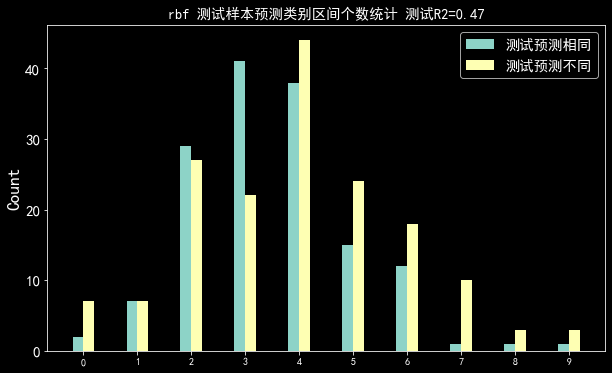

In [651]:
# 绘制训练样本类别预测与目标分类的相同和不同的概率区别统计图
plt.style.use(plt.style.available[4])  #可以通过下标进行选择适合自己的样式
plt.rcParams['font.sans-serif'] = ['SimHei']  #指定默认字体,用来正常显示中文标签
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False  #用来正常显示负号

id_test_no = clf.predict(x_test_stand)[:] != y_test.ravel()  #测试样本预测类别与测试目标类别不同的下标
id_test_ok = clf.predict(x_test_stand)[:] == y_test.ravel()  #测试样本预测类别与测试目标类别不同的下标
test_no = clf.predict_proba(x_test_stand)[id_test_no]  #测试样本预测类别与测试目标类别不同的概率值
test_ok = clf.predict_proba(x_test_stand)[id_test_ok]

# 绘制测试样本类别预测与目标分类的相同和不同的概率区别统计图
his_test_ok, _ = np.histogram(test_ok, bins=10)
his_test_no, _ = np.histogram(test_no, bins=10)
# 绘制图像
fig, ax1 = plt.subplots()
fig.set_size_inches(10, 6)
# plt.set_cmap('RdBu')
plt.set_cmap('jet')
x = np.arange(len(_) - 1)
w = 0.1
# 绘制多个bar在同一个图中, 这里需要控制width
plt.bar(x - 1 * w, height=his_test_ok, width=2 * w, align='center')  #测试样本预测相同
plt.bar(x + 1 * w, height=his_test_no, width=2 * w, align='center')  #测试样本预测不同
# 设置坐标轴的标签
ax1.yaxis.set_tick_params(labelsize=15)  # 设置y轴的字体的大小
ax1.set_xticks(x)  # 设置xticks出现的位置
# 设置坐标轴名称
ax1.set_ylabel("Count", fontsize='xx-large')
# 设置标题
ax1.set_title('%s 测试样本预测类别区间个数统计 测试R2=%.2f' % (clf.kernel, score_test), fontsize='x-large')
# 设置图例
plt.legend(('测试预测相同', '测试预测不同'), fontsize='x-large', loc='upper right')
plt.show()

In [652]:
print(y_train[:10].ravel())
print(y_test[:10].ravel())
print(x_train_stand.shape, x_test_stand.shape)
print(y_train.shape, y_train.ndim)
print(x_test_stand[:5])
print(y_test_pred[:50].ravel())

[ 0. -1.  0.  0. -1. -1. -1.  1.  1.  1.]
[ 1.  0.  0.  1.  1.  1. -1.  1.  0.  1.]
(104, 4) (104, 4)
(104, 1) 2
[[-0.569 -0.538 -0.382 -0.577]
 [-1.489 -1.52  -1.402 -1.5  ]
 [-1.683 -1.622 -1.585 -1.553]
 [ 0.993  0.91   1.207  1.1  ]
 [-0.018 -0.185 -0.052 -0.21 ]]
[ 1. -1.  0.  0.  0.  1. -1.  1. -1.  1.  1.  0.  1.  0. -1. -1.  1.  1.
  0.  1. -1.  0.  0.  0. -1. -1.  1.  1. -1.  0. -1. -1.  1.  0.  1.  1.
  0.  1. -1. -1.  1.  0.  0. -1.  1.  1. -1. -1.  1. -1.]
